# Slope Management

Slope management is a technique to deal with an oddity between the fourier transform reconstructor and real telescope systesm. Simply, slope management provides slopes to the fourier transform which are compatible with the fourier transform assumption that all things which are fourier transformed are fully periodic.

## System Setup

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from FTR.utils import circle_aperture, remove_piston, remove_tiptilt

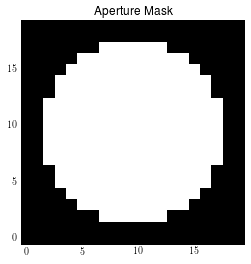

In [4]:
shape = (20, 20)
r = 8
ap = circle_aperture(shape, r)
plt.imshow(ap, cmap='binary_r')
plt.title("Aperture Mask")

In [5]:
def remove_ttp(data):
    pr, p = remove_piston(ap, data)
    tr, tx, ty = remove_tiptilt(ap, pr)
    return tr

# Initial Slopes

We'll reconstruct focus, because its simple x and y slopes

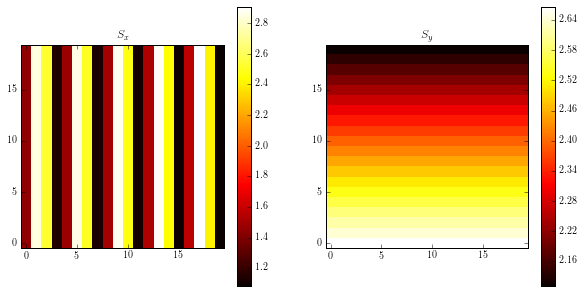

In [61]:
xs = -np.sin(np.linspace(-10,20,20)[None,:]) * np.ones((20,1)) + 2 
ys = (-np.cos(4*np.linspace(-10,20,20)[:,None]) * np.ones((1,20)) + 2)
f, (ax_x, ax_y) = plt.subplots(1, 2, figsize=(10,5))
im = ax_x.imshow(xs, cmap='hot')
ax_x.set_title("$S_x$")
f.colorbar(im, ax=ax_x)
im = ax_y.imshow(ys, cmap='hot')
ax_y.set_title("$S_y$")
f.colorbar(im, ax=ax_y)

# Fourier Reconstruction

The naieve Fourier Reconstruction on the unapertured, fully-periodic grid, works just fine

In [62]:
from FTR import FourierTransformReconstructor as FTRecon

In [63]:
recon = FTRecon(np.ones_like(ap), filter='mod_hud', suppress_tt=True)

<FourierTransformReconstructor (20x20) filter='mod_hud' tt='suppressed'>

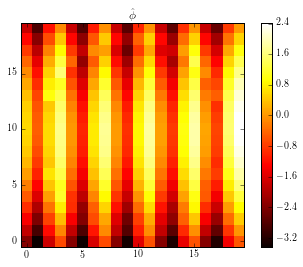

In [64]:
phi = recon(xs, ys)
plt.imshow(remove_ttp(phi), cmap='hot')
plt.title(r"$\hat{\phi}$")
plt.colorbar()
recon

## Apertured Reconstruction

However, if we aperture the slopes before reconstruction, we get a significantly worse reconstruction, due to the zeros present outside the aperture.

<FourierTransformReconstructor (20x20) filter='mod_hud' tt='suppressed'>

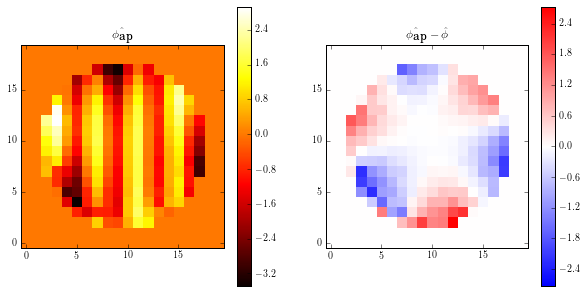

In [65]:
phi_ap = recon(xs * ap, ys * ap)
f, (ax_p, ax_r) = plt.subplots(1, 2, figsize=(10,5))
im = ax_p.imshow(remove_ttp(phi_ap) * ap, cmap='hot')
ax_p.set_title(r"$\hat{\phi_{\textrm{ap}}}$")
f.colorbar(im, ax=ax_p)
phi_ap_fa = remove_tiptilt(ap, remove_piston(ap, phi_ap - phi)[0])[0] * ap
dmax = np.max(np.abs(phi_ap_fa))
im = ax_r.imshow(phi_ap_fa, cmap='bwr', vmin=-dmax, vmax=dmax)
ax_r.set_title(r"$\hat{\phi_{\textrm{ap}}} - \hat{\phi}$")
f.colorbar(im, ax=ax_r)
recon

## Slope Management

Slope management avoids the non-periodic nature of apertured slopes by using the points outside the aperture to create fake slopes which obey the peridoicity relation.

In [66]:
from FTR.slopemanage import slope_management, SlopeManagedFTR

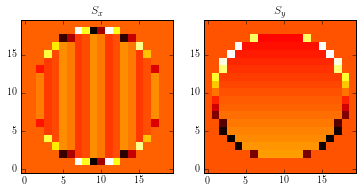

In [67]:
ys_m, xs_m = slope_management(ap, remove_piston(ap,ys)[0] * ap, remove_piston(ap,xs)[0] * ap)
f, (ax_x, ax_y) = plt.subplots(1, 2)
ax_x.imshow(xs_m, cmap='hot')
ax_x.set_title("$S_x$")
ax_y.imshow(ys_m, cmap='hot')
ax_y.set_title("$S_y$")

<SlopeManagedFTR (20x20) filter='mod_hud' tt='suppressed'>

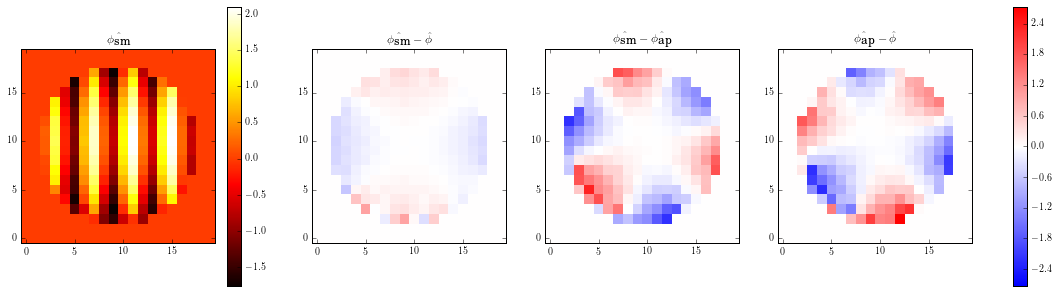

In [68]:
recon = SlopeManagedFTR(ap, filter='mod_hud', suppress_tt=True)
phi_sm = recon(xs, ys)
f, (ax_p, ax_r, ax_ar, ax_fr) = plt.subplots(1, 4, figsize=(20,5))
im = ax_p.imshow(phi_sm * ap, cmap='hot')
ax_p.set_title(r"$\hat{\phi_{\textrm{sm}}}$")
f.colorbar(im, ax=ax_p)

phi_sm_fa = remove_tiptilt(ap, remove_piston(ap, phi_sm - phi)[0])[0] * ap
phi_sm_ap = remove_tiptilt(ap, remove_piston(ap, phi_sm - phi_ap)[0])[0] * ap
dmax = np.max(np.abs([phi_sm_fa, phi_sm_ap, phi_ap_fa]))

im = ax_r.imshow(phi_sm_fa, cmap='bwr', vmin=-dmax, vmax=dmax)
ax_r.set_title(r"$\hat{\phi_{\textrm{sm}}} - \hat{\phi}$")

im = ax_ar.imshow(phi_sm_ap, cmap='bwr', vmin=-dmax, vmax=dmax)
ax_ar.set_title(r"$\hat{\phi_{\textrm{sm}}} - \hat{\phi_\textrm{ap}}$")

im = ax_fr.imshow(phi_ap_fa, cmap='bwr', vmin=-dmax, vmax=dmax)
ax_fr.set_title(r"$\hat{\phi_{\textrm{ap}}} - \hat{\phi}$")
f.colorbar(im, ax=[ax_r, ax_ar, ax_fr])


recon